In [1]:
import cv2
import time
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import bar

from thinning import zhangSuen
from skimage.filters import threshold_otsu
from skimage.morphology import skeletonize

In [2]:
def show_images(images,titles=None):
    #This function is used to show image(s) with titles by sending an array of images and an array of associated titles.
    # images[0] will be drawn with the title titles[0] if exists
    # You aren't required to understand this function, use it as-is.
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure()
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n)
        if image.ndim == 2: 
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        n += 1
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_ims)
    plt.show()

In [3]:
def showHist(hist):
    plt.figure()
    bar(np.arange(len(hist)), hist, width=0.8, align='center')

In [4]:
def thin(img):
    img = np.invert(img)
    
    Otsu_Threshold = threshold_otsu(img)
    thresholded = img < Otsu_Threshold    # must set object region as 1, background region as 0 !

    return zhangSuen(thresholded)

In [5]:
def breakLines(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    ## (2) threshold
    th, threshed = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV|cv2.THRESH_OTSU)
    pts = cv2.findNonZero(threshed)
    ret = cv2.minAreaRect(pts)

    ## (3) minAreaRect on the nozeros
    H,W = img.shape[:2]
    (cx,cy), (w,h), ang = ret
    
    if (H > W and w > h) or (H < W and w < h):
        w,h = h,w
        ang += 90

    # ## (4) Find rotated matrix, do rotation
    M = cv2.getRotationMatrix2D((cx,cy), ang, 1.0)
    rotated = cv2.warpAffine(threshed, M, (img.shape[1], img.shape[0]))
    
    ## (5) find and draw the upper and lower boundary of each lines
    hist = cv2.reduce(rotated, 1, cv2.REDUCE_AVG).reshape(-1)

    th = 2
    uppers = [y for y in range(H-1) if hist[y]<=th and hist[y+1]>th]
    lowers = [y for y in range(H-1) if hist[y]>th and hist[y+1]<=th]
    
    uppers_mod = [uppers[0]]
    lowers_mod = [lowers[0]]
    
    for i in range(1, len(uppers)):
        if (lowers[i] - lowers[i-1]) > 10:
            uppers_mod.append(uppers[i])
            lowers_mod.append(lowers[i])

    lines = []
    if len(uppers_mod) == len(lowers_mod):
        for i in range(len(uppers_mod)):
            lines.append(rotated[uppers_mod[i]-5:lowers_mod[i]+5, :])

    return lines

In [6]:
def breakWords(line):
    H, W = line.shape
    hist = cv2.reduce(line, 0, cv2.REDUCE_AVG).reshape(-1)

    th = 2
    lefts = [x for x in range(W-1) if hist[x] <= th and hist[x+1] > th]
    rights = [x for x in range(W-1) if hist[x] > th and hist[x+1] <= th]

    words = []
    if len(lefts) == len(rights):
        for i in range(len(rights)):
            words.append(line[:, lefts[i]:rights[i]])

    return words

In [7]:
def addCharSeparetor(word):
    binary = word.copy()
    binary[binary <= 127] = 0
    binary[binary > 127] = 1
    skeleton = skeletonize(binary) + 0
    hist = []
    for i in range(skeleton.shape[1]):
        hist.append(np.sum(skeleton[:, i]))

    diff = np.diff(hist)
    splitters = np.where(diff > 0)[0]
    mod_splitters = [splitters[0]]
    for i in range(1, len(splitters)):
        if splitters[i] - splitters[i-1] >= 5:
            mod_splitters.append(splitters[i])

#     bgr_skeleton = cv2.cvtColor((255 * (skeleton + 0)).astype(np.uint8), cv2.COLOR_GRAY2BGR)
#     for splitter in mod_splitters:
#         cv2.line(bgr_skeleton, (splitter, 0), (splitter, bgr_skeleton.shape[1]), (255, 0, 0), 1)
    characters = [word[:, 0:mod_splitters[0]]]
    for i in range(1, len(mod_splitters)):
            characters.append(word[:, mod_splitters[i-1]:mod_splitters[i]])

    return characters

In [10]:
def demo(img):
    start_time = time.time()
    lines = breakLines(img)
    print("image to lines run time = %s secs" % (time.time() - start_time))

    counter = 0
    line_chars = []
    wordToCharsTimes = []
    for line in lines:
        start_time = time.time()
        words = breakWords(line)
        print("line_%s to words run time = %s secs" % (counter, (time.time() - start_time)))
        
        chars = []
        start_time = time.time()
        for word in words:
            startTime = time.time()
            chars.append(addCharSeparetor(word))
            wordToCharsTimes.append(time.time() - startTime)
        line_chars.append(chars)

        print("line_%s to characters run time = %s secs" % (counter, (time.time() - start_time)))
        print("--------------------------------------------------------------------------------")
        counter += 1
    
    wordToCharsTimes = np.array(wordToCharsTimes)
    print("average word to characters run time = %s secs" % np.average(wordToCharsTimes))

In [11]:
img = cv2.imread("./DataSets/test1.png")
start_time = time.time()
demo(img)
print("overAll Run Time = %s secs" % (time.time() - start_time))

image to lines run time = 0.04587221145629883 secs
line_0 to words run time = 0.01230621337890625 secs
line_0 to characters run time = 0.023282527923583984 secs
--------------------------------------------------------------------------------
line_1 to words run time = 0.008039712905883789 secs
line_1 to characters run time = 0.007098674774169922 secs
--------------------------------------------------------------------------------
line_2 to words run time = 0.004056692123413086 secs
line_2 to characters run time = 0.00903463363647461 secs
--------------------------------------------------------------------------------
line_3 to words run time = 0.004142045974731445 secs
line_3 to characters run time = 0.006708860397338867 secs
--------------------------------------------------------------------------------
line_4 to words run time = 0.004686594009399414 secs
line_4 to characters run time = 0.0055387020111083984 secs
-----------------------------------------------------------------------

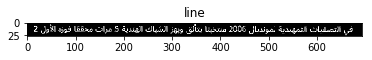

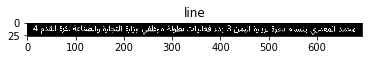

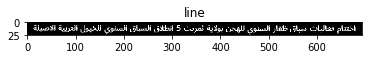

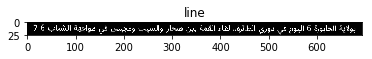

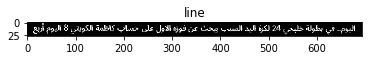

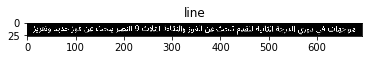

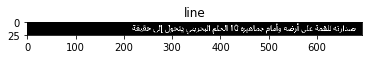

In [12]:
## (1) read
img1 = cv2.imread("./DataSets/test1.png")
lines = breakLines(img1)
for line in lines:
    show_images([line], ["line"])

# words = breakWords(lines[0])

# for word in words:
#     thinned = thin(word.copy())
#     binary = word.copy()
#     binary[binary <= 127] = 0
#     binary[binary > 127] = 1
#     skeleton = skeletonize(binary)
    
#     show_images([word, thinned, binary, skeleton], ["word", "thinned", "binary", "skeletonized"])

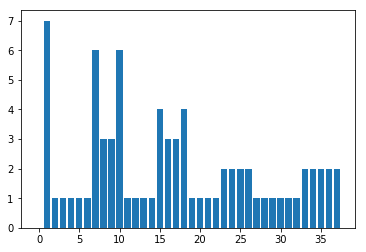

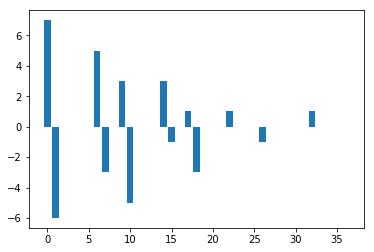

In [16]:
word = words[5]
binary = word.copy()
binary[binary <= 127] = 0
binary[binary > 127] = 1
skeleton = skeletonize(binary) + 0
hist = []
for i in range(skeleton.shape[1]):
    hist.append(np.sum(skeleton[:, i]))
            
# print(hist)
# print(np.diff(hist))
diff = np.diff(hist)
splitters = np.where(diff > 0)[0]
mod_splitters = [splitters[0]]
for i in range(1, len(splitters)):
    if splitters[i] - splitters[i-1] >= 3:
        mod_splitters.append(splitters[i])

bgr_skeleton = cv2.cvtColor((255 * (skeleton + 0)).astype(np.uint8), cv2.COLOR_GRAY2BGR)
for splitter in mod_splitters:
    cv2.line(bgr_skeleton, (splitter, 0), (splitter, bgr_skeleton.shape[1]), (255, 0, 0), 1)
    
# show_images([word, skeleton, bgr_skeleton], ["original", "skeleton", "skeleton with character separators"])
showHist(hist)
showHist(np.diff(hist))

In [ ]:
word = words[5]
binary = word.copy()
binary[binary <= 127] = 0
binary[binary > 127] = 1
skeleton = skeletonize(binary)
bgr_skeleton = cv2.cvtColor((255 * (skeleton + 0)).astype(np.uint8), cv2.COLOR_GRAY2BGR)
skeleton = skeleton.astype(np.uint8)

#find contours
ctrs, hier = cv2.findContours(skeleton.copy(), cv2.RETR_EXTERNAL, 
cv2.CHAIN_APPROX_SIMPLE)

# #sort contours
sorted_ctrs = sorted(ctrs, key=lambda ctr: cv2.boundingRect(ctr)[0])

for i, ctr in enumerate(sorted_ctrs):
#     if i == 3:
#         break
    # Get bounding box
    x, y, w, h = cv2.boundingRect(ctr)

    # Getting ROI
#     roi = bgr_skeleton[y:y+h, x:x+w]

    # show ROI
    #cv2.imwrite('roi_imgs.png', roi
#     show_images([roi], ['charachter' + str(i)])
#     cv2.line(bgr_skeleton, (x, 0), (x, bgr_skeleton.shape[1]), (0, 0, 255), 1)
#     cv2.line(bgr_skeleton, (x+w, 0), (x+w, bgr_skeleton.shape[1]), (0, 255, 0), 1)
    if i < 2:
        continue
    cv2.rectangle(bgr_skeleton, (x, y), (x+w, y+h), (90, 0, 255), 1)

show_images([bgr_skeleton], ['marked areas'])

In [ ]:
# Copy edges to the images that will display the results in BGR
# word = words[4]
# binary = word.copy()
# binary[binary <= 127] = 0
# binary[binary > 127] = 1
# skeleton = skeletonize(binary)
# skeleton = 255 * (skeleton + 0)
# skeleton = skeleton.astype(np.uint8)

# cdst = cv2.cvtColor(skeleton, cv2.COLOR_GRAY2BGR)
# cdstP = np.copy(cdst)

# lines = cv2.HoughLines(skeleton, 1, np.pi / 180, 150, None, 0, 0)
# print(lines)

# if lines is not None:
#     for i in range(0, len(lines)):
#         rho = lines[i][0][0]
#         theta = lines[i][0][1]
#         a = math.cos(theta)
#         b = math.sin(theta)
#         x0 = a * rho
#         y0 = b * rho
#         pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
#         pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
#         cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv.LINE_AA)


# linesP = cv2.HoughLinesP(skeleton, 1, np.pi / 180, 50, None, 50, 10)
# print(linesP)

# if linesP is not None:
#     for i in range(0, len(linesP)):
#         l = linesP[i][0]
#         cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv.LINE_AA)
        

# show_images(
#     [skeleton, cdst, cdstP],
#     [
#         "Source",
#         "Detected Lines (in red) - Standard Hough Line Transform",
#         "Detected Lines (in red) - Probabilistic Line Transform"
#     ]
# )